# CMA-ES

In [204]:
import numpy as np
import cma
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
from typing import Callable

np.random.seed(42)

### Optimization Problems

This cell defines three common benchmark functions, Sphere, Rosenbrock, and Rastrigin, used to test optimization algorithms. We also used these functions earlier to evaluate Adam and Momentum.

In [205]:
def sphere(x: np.ndarray) -> float:
    return float(np.sum(x**2))


def rosenbrock(x: np.ndarray) -> float:
    return float(np.sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1.0 - x[:-1]) ** 2.0))


def rastrigin(x: np.ndarray) -> float:
    A: float = 10.0
    return float(A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x)))

### Helper functions

Convergence plot and animation.

In [206]:
def plot_convergence(histories: dict[str, list[float]]) -> None:
    plt.figure()
    for name, fitness in histories.items():
        plt.plot(fitness, label=name)
        # plt.semilogy(fitness, label=name)
    plt.ylim(0,50)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("CMA-ES Convergence")
    plt.legend()
    plt.grid(True)
    plt.show()

def animate_distribution(
    func: Callable[[np.ndarray], float],
    mu_history: list[np.ndarray],
    cov_history: list[np.ndarray],
    bounds: tuple[float, float] = (-5, 5),
    frames: int = 50,
    filename: str = "cma_es_animation.mp4",
) -> None:
    x = np.linspace(bounds[0], bounds[1], 200)
    y = np.linspace(bounds[0], bounds[1], 200)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T
    Z = np.array([func(pt) for pt in coords]).reshape(X.shape)

    fig, ax = plt.subplots()
    levels = np.logspace(np.log10(Z.min() + 1e-6), np.log10(Z.max()), 30)

    def update(frame_index: int) -> None:
        ax.clear()
        ax.contour(X, Y, Z, levels=levels, cmap="viridis")
        mu = mu_history[frame_index]
        cov = cov_history[frame_index]
        vals, vecs = np.linalg.eigh(cov)
        angle = float(np.degrees(np.arctan2(vecs[0, 1], vecs[0, 0])))
        width, height = 2 * np.sqrt(vals)
        ellipse = Ellipse(
            xy=mu,
            width=width,
            height=height,
            angle=angle,
            edgecolor="red",
            facecolor="none",
            lw=2,
        )
        ax.add_patch(ellipse)
        ax.plot(mu[0], mu[1], "ro")
        ax.set_title(f"Generation {frame_index}")
        ax.set_xlim(bounds)
        ax.set_ylim(bounds)

    anim = FuncAnimation(fig, update, frames=min(frames, len(mu_history)), interval=200)
    anim.save(filename, writer="ffmpeg")
    print(f"Animation saved to {filename}")

### Running CMA-ES

In [207]:
from dataclasses import dataclass

@dataclass
class CMAESResult:
    best_fitness: list[float]
    mean_history: list[np.ndarray]
    cov_history: list[np.ndarray]
    sigma_history: list[float]

def run_cma_es(
    func: Callable[[np.ndarray], float],
    x0: np.ndarray,
    sigma0: float,
    max_iterations: int = 100,
    eval_budget: int = 1000
) -> CMAESResult:
    """
    Run CMA-ES on a black-box objective `func`, starting at mean x0 with step-size sigma0.
    Stops when we exceed max_iterations OR run out of eval_budget.
    Returns histories of best_fitness, mean, covariance, and sigma per generation.
    """
    best_fitness = []
    mean_history = []
    cov_history = []
    sigma_history = []

    es = cma.CMAEvolutionStrategy(x0, sigma0)
    mean_history.append(es.mean.copy())
    cov_history.append(es.C.copy())
    sigma_history.append(es.sigma)

    total_evaluations = 0

    for generation in range(max_iterations):
        candidates = es.ask()        # a batch of lambda candidates in this generation
        lam = len(candidates)

        # how many candidates can be evaluated without exceeding eval_budget
        if eval_budget and total_evaluations + lam > eval_budget:
            allowed = eval_budget - total_evaluations
        else:
            allowed = lam

        # evaluate exactly 'allowed' candidates
        fitnesses = []
        for i in range(allowed):
            fx = func(candidates[i])
            fitnesses.append(fx)
            total_evaluations += 1

        # if fewer evaluated than lambda, pad the rest because cma.tell expects lambda candidates
        if allowed < lam:
            pad_count = lam - allowed
            # choose a sufficiently large value so that CMA-ES treats these as “worst” and does not evaluate
            fitnesses += [max(fitnesses) + 1e6] * pad_count
            reached_budget = True
        else:
            reached_budget = False

        gen_best = min(fitnesses)
        best_fitness.append(gen_best)

        es.tell(candidates, fitnesses)
        # record updated distribution parameters
        mean_history.append(es.mean.copy())
        cov_history.append(es.C.copy())
        sigma_history.append(es.sigma)

        # stop if we got below 1e-8, or ran out of evaluations, or CMA-ES signals stop
        if gen_best < 1e-8:
            print(f"Stopped at gen {generation+1}: best fitness {gen_best:.3e} < 1e-8")
            break
        if reached_budget:
            print(f"Reached evaluation budget ({eval_budget}) at gen {generation+1}")
            break
        # if es.stop():
        #     print(f"CMA-ES signaled termination at gen {generation+1}")
        #     break

    return CMAESResult(
        best_fitness=best_fitness,
        mean_history=mean_history,
        cov_history=cov_history,
        sigma_history=sigma_history
    )

### Ex. 1: Impact of the Starting Point
1.	Choose Rosenbrock in 2D.
2.	Run CMA-ES from at least five widely separated initial means (e.g., [-4,-4], [-1,3], [5,5]).
3.	Plot convergence curves and report:
- best fitness vs. generation,
- total evaluations to reach $f(x)\lt10^{-8}$ (or termination).
4.	Briefly discuss sensitivity to the start point. Prepare GIFs for two different starting points.

Hint: use `sigma0 = 0.5` and `max_iter = 250`.

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=248681, Thu Jun  5 14:09:44 2025)
Stopped at gen 72: best fitness 9.890e-09 < 1e-8
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=154300, Thu Jun  5 14:09:44 2025)
Stopped at gen 45: best fitness 5.368e-10 < 1e-8
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=187335, Thu Jun  5 14:09:44 2025)
Stopped at gen 127: best fitness 8.521e-09 < 1e-8
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=262299, Thu Jun  5 14:09:44 2025)
Stopped at gen 58: best fitness 6.619e-09 < 1e-8
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=242804, Thu Jun  5 14:09:44 2025)
Stopped at gen 104: best fitness 9.494e-09 < 1e-8


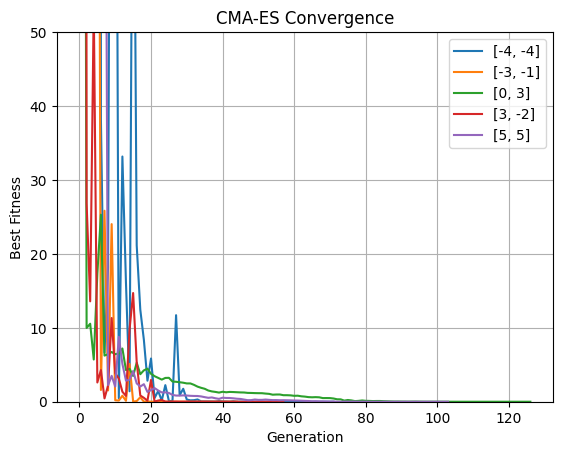

In [208]:
means = [[-4, -4], [-3, -1], [0, 3], [3, -2], [5, 5]]
sigma0 = 0.5
max_iter = 250

histories = {}

for x0 in means:
    cma_result = run_cma_es(rosenbrock, x0, sigma0, max_iter)
    histories[str(x0)] = cma_result.best_fitness

plot_convergence(histories)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=263551, Thu Jun  5 14:09:44 2025)
Stopped at gen 107: best fitness 3.712e-09 < 1e-8
Animation saved to cma_es_animation_03.mp4
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=255067, Thu Jun  5 14:09:50 2025)
Stopped at gen 160: best fitness 2.048e-09 < 1e-8
Animation saved to cma_es_animation_-4-4.mp4


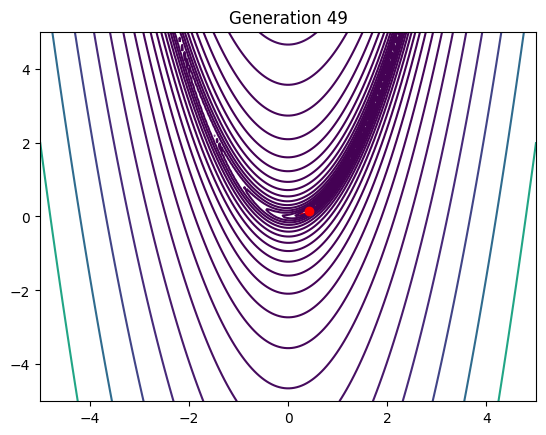

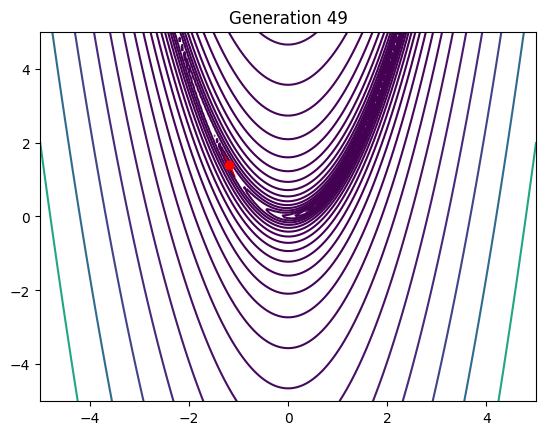

In [209]:
means = [[0, 3], [-4, -4]]

# animations for two different starting points
for x0 in means:
    cma_result = run_cma_es(rosenbrock, x0, sigma0, max_iter)
    animate_distribution(rosenbrock, cma_result.mean_history, cma_result.cov_history, filename = f"cma_es_animation_{x0[0]}{x0[1]}.mp4")

### Observations:
- Runs that start closer to the Rosenbrock valley (for example, [0, 3] or [3, –2]) reach values below 10^-8 in far fewer generations than those starting farther away (like [–4, –4] or [5, 5])
- This shows that CMA-ES is sensitive to the initial mean - starting close to the global minimum allows CMA-ES to converge in fewer generations than for initial mean values located further away

### Ex. 2: Effect of the Initial Global Step‐Size $\sigma_0$
1. Use [2,2] at starting point on the Rastrigin function.
2. Test $\sigma_0\in\{0.1,\,0.5,\,1,\,2,\,5\}$.
3. Record and plot
- final fitness after a fixed budget (e.g. 1000 evals)
- evolution of es.sigma over time (log scale).
4. Explain why too-small and too-large $\sigma_0$ hurt performance, relating findings to the adaptation rule.

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=171283, Thu Jun  5 14:09:56 2025)
Reached evaluation budget (1000) at gen 167
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=177528, Thu Jun  5 14:09:56 2025)
Reached evaluation budget (1000) at gen 167
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=223558, Thu Jun  5 14:09:56 2025)
Reached evaluation budget (1000) at gen 167
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=231495, Thu Jun  5 14:09:56 2025)
Reached evaluation budget (1000) at gen 167
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=205989, Thu Jun  5 14:09:56 2025)
Reached evaluation budget (1000) at gen 167


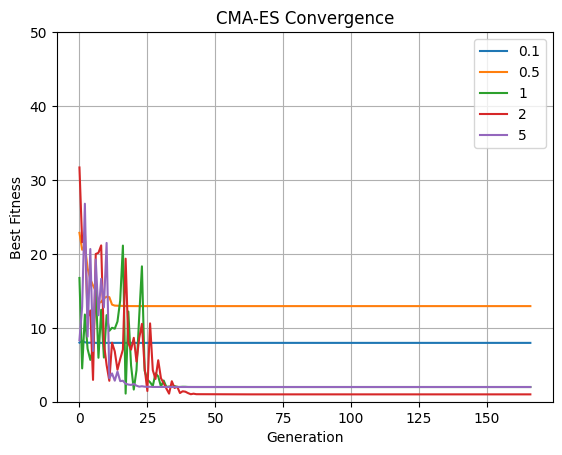

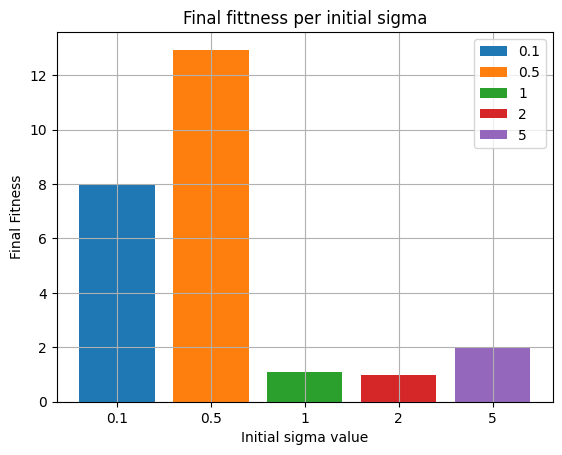

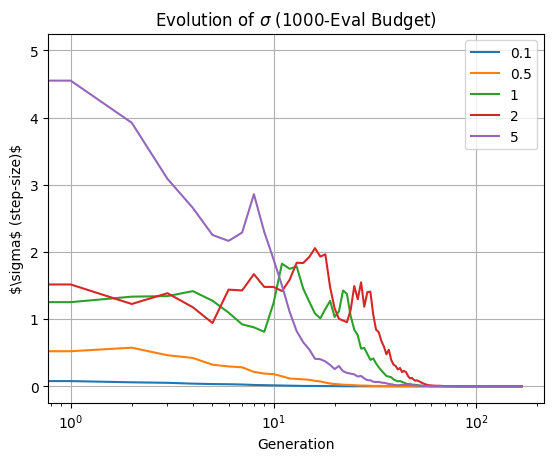

In [210]:
x0 = [2,2]
sigma = [0.1, 0.5, 1, 2, 5]
budget = 1000
best_fitness = []
histories = {}
sigma_histories = {}

for sigma0 in sigma:
    cma_result = run_cma_es(rastrigin, x0, sigma0, max_iterations=500, eval_budget=budget)
    histories[str(sigma0)] = cma_result.best_fitness
    sigma_histories[str(sigma0)] = cma_result.sigma_history

plot_convergence(histories)

plt.figure()
for name, fitness in histories.items():
    plt.bar(name, min(fitness), label=name)
plt.xlabel("Initial sigma value")
plt.ylabel("Final Fitness")
plt.title("Final fittness per initial sigma")
plt.legend()
plt.grid(True)
plt.show()


plt.figure()
for name, sigma_evolution in sigma_histories.items():
    plt.semilogx(sigma_evolution, label=name)
plt.xlabel("Generation")
plt.ylabel(f"$\\sigma$ (step‐size)$")
plt.title('Evolution of $\\sigma$ (1000‐Eval Budget)')
plt.legend()
plt.grid(True)
plt.show()

### Observations:
- the final fitness plot shows that for too small and too large initial sigmas CMA-ES failed to converge withing the budget - this shows that choosing sigma has influence on how computationally effective the algorithm is
- the evolution of sigma over generations shows that for too small initial sigmas (0.1 and 0.5) the step‐size collapses generation after generation - this means CMA-ES never really “explores” beyond a tiny patch, so it can’t find deeper optima
- too big initial sigma (5) causes most samples to land in poor regions and CMA-ES’s adaptation rule aggressively shrinks sigma and it might fail to "notice" (or do it later) areas worth exploring as compared for example to the green plot (1)
- in short, choosing a moderate sigma (around 1 or 2 here) lets CMA-ES keep enough search radius to discover good regions and then shrink at a healthy pace, so it converges much faster under a fixed evaluation budget

### Ex. 3: Visualising the Covariance Matrix Adaptation
1. On Sphere in 2D, log es.C every 5 generations.
2. Use the provided `animate_distribution` to produce a GIF showing the shrinking and rotation of the sampling ellipse.
3. Submit the animation and two short observations about what the animation reveals regarding step-size vs. shape adaptation.

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=157117, Thu Jun  5 14:09:57 2025)
Stopped at gen 38: best fitness 7.701e-09 < 1e-8


[array([[1.     , 0.     ],
        [0.     , 1.00005]]),
 array([[ 0.41271639, -0.0552493 ],
        [-0.0552493 ,  0.76469224]]),
 array([[0.14242055, 0.00674763],
        [0.00674763, 0.43061644]]),
 array([[ 0.12171721, -0.0545082 ],
        [-0.0545082 ,  0.19049316]]),
 array([[ 0.03345703, -0.00970882],
        [-0.00970882,  0.06991029]]),
 array([[0.01323641, 0.00023777],
        [0.00023777, 0.02521313]]),
 array([[ 0.00605908, -0.00264838],
        [-0.00264838,  0.0079263 ]]),
 array([[ 0.00255571, -0.00034488],
        [-0.00034488,  0.00289828]])]

Animation saved to cma_es_animation.mp4


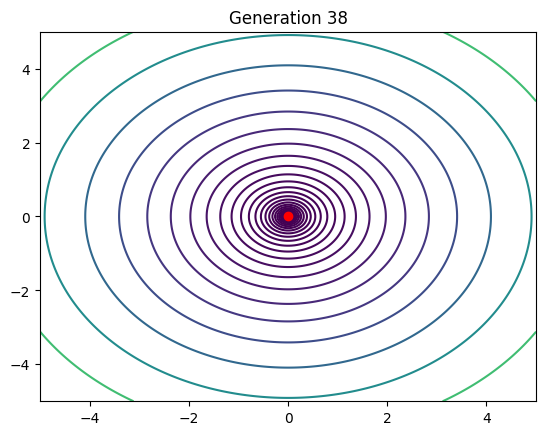

In [211]:
x0 = [-4, -4]
std = 1
cma_result = run_cma_es(sphere, x0, sigma0, max_iter, eval_budget=budget)

display([C for i, C in enumerate(cma_result.cov_history) if i % 5 == 0])
animate_distribution(sphere, cma_result.mean_history, cma_result.cov_history)

### Observations:
- based on the covariance matrix logs and on the animation it can be observed that the ellipse is wider in the initial generations and shrinks with consecutive generations once it approaches the minimum - this is the sigma step-size
- it can also be observed that CMA‐ES initially rotates its covariance ellipse so its long axis points downhill toward [0,0] and then as sigma shrinks and the mean is close to the minimum, that tilt vanishes and the ellipse collapses into an almost circular shape

# The Cart Pole exercise

Here are the results obtained for running CMA-ES as the optimisation algorithm for finding optimal parameters in the reinforcement learning task of balancing a pole on a cart. It can be observed that CMA learns the optimal parametrers fast (even in the 3rd generation) achieving the goal of balancing the pole.
![](img_1.png)
![](img.png)
